In [100]:
import numpy as np
import pandas as pd
import polars as pl
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from lets_plot import *
LetsPlot.setup_html()

In [101]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("API_KEY")

import mosqlient

In [102]:
# from mosqlient import get_all_authors

# get_all_authors(api_key)

In [103]:
data = pl.read_parquet('../../ds-spatiotemporal-mosqlimate/data/03_primary/dataset_complete_dengue_uf.parquet')
data = data.rename({'casos': 'target'})
# data = data.to_pandas()

In [104]:
exo = ['precip_min','precip_max','temp_min','temp_max','pressure_min','pressure_max','population']
train_1 = data.filter(pl.col('train_1'))[['uf','date','target',*exo]]
train_1 = TimeSeriesDataFrame.from_data_frame(train_1.to_pandas(),id_column='uf',timestamp_column='date')
test_1 =  data.filter(
    pl.col('target_1') | (
        # ~pl.col('train_1') & 
        (pl.col('date') < np.max(np.array(data.filter(pl.col('target_1')).sort('date')['date'])))
    )
)[['uf','date','target',*exo]]
test_1 = TimeSeriesDataFrame.from_data_frame(test_1.to_pandas(),id_column='uf',timestamp_column='date')

In [105]:
end_1 = np.array(data.filter(pl.col('train_1')).sort('date')['epiweek'])[-1]
end_2 = np.array(data.filter(pl.col('target_1')).sort('date')['epiweek'])[-1]

# prediction_length = (init_2 - end_1) + test_1.reset_index()[test_1.reset_index()['item_id'] == 'CE'].shape[0]
# prediction_length = end_2 - end_1
prediction_length = 68

In [93]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="target",
).fit(
    train_data=train_1,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
            {"model_path": "bolt_small",
             "covariate_regressor": "CAT",
             "target_scaler": "standard",
             "fine_tune": True,
             "ag_args": {"name_suffix": "FineTuned-Covariates"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
    # presets='fast_training'
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/davibarreira/Documents/DSProjects/Mosqlimate/mosqlimate-sprint/notebooks/AutogluonModels/ag-20250714_160705'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          0
Memory Avail:       4.94 GB / 16.00 GB (30.9%)
Disk Space Avail:   413.08 GB / 926.35 GB (44.6%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_pa

In [106]:
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.541021,-0.672974,0.692269,0.215092,24.697102,2
1,ChronosFineTuned-Covariates[bolt_small],-0.554983,-0.673019,0.830503,0.284588,28.069278,3
2,ChronosZeroShot[bolt_small],-0.602265,-0.670684,1.741327,1.992873,0.015438,1


In [13]:
predictions = predictor.predict(train_1,model='ChronosFineTuned[bolt_small]')

/var/folders/sz/kh2xcmy51n70hznv18vzsqxr0000gn/T/ipykernel_11661/3891486509.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ufs = pd.unique(data['uf'])
data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.


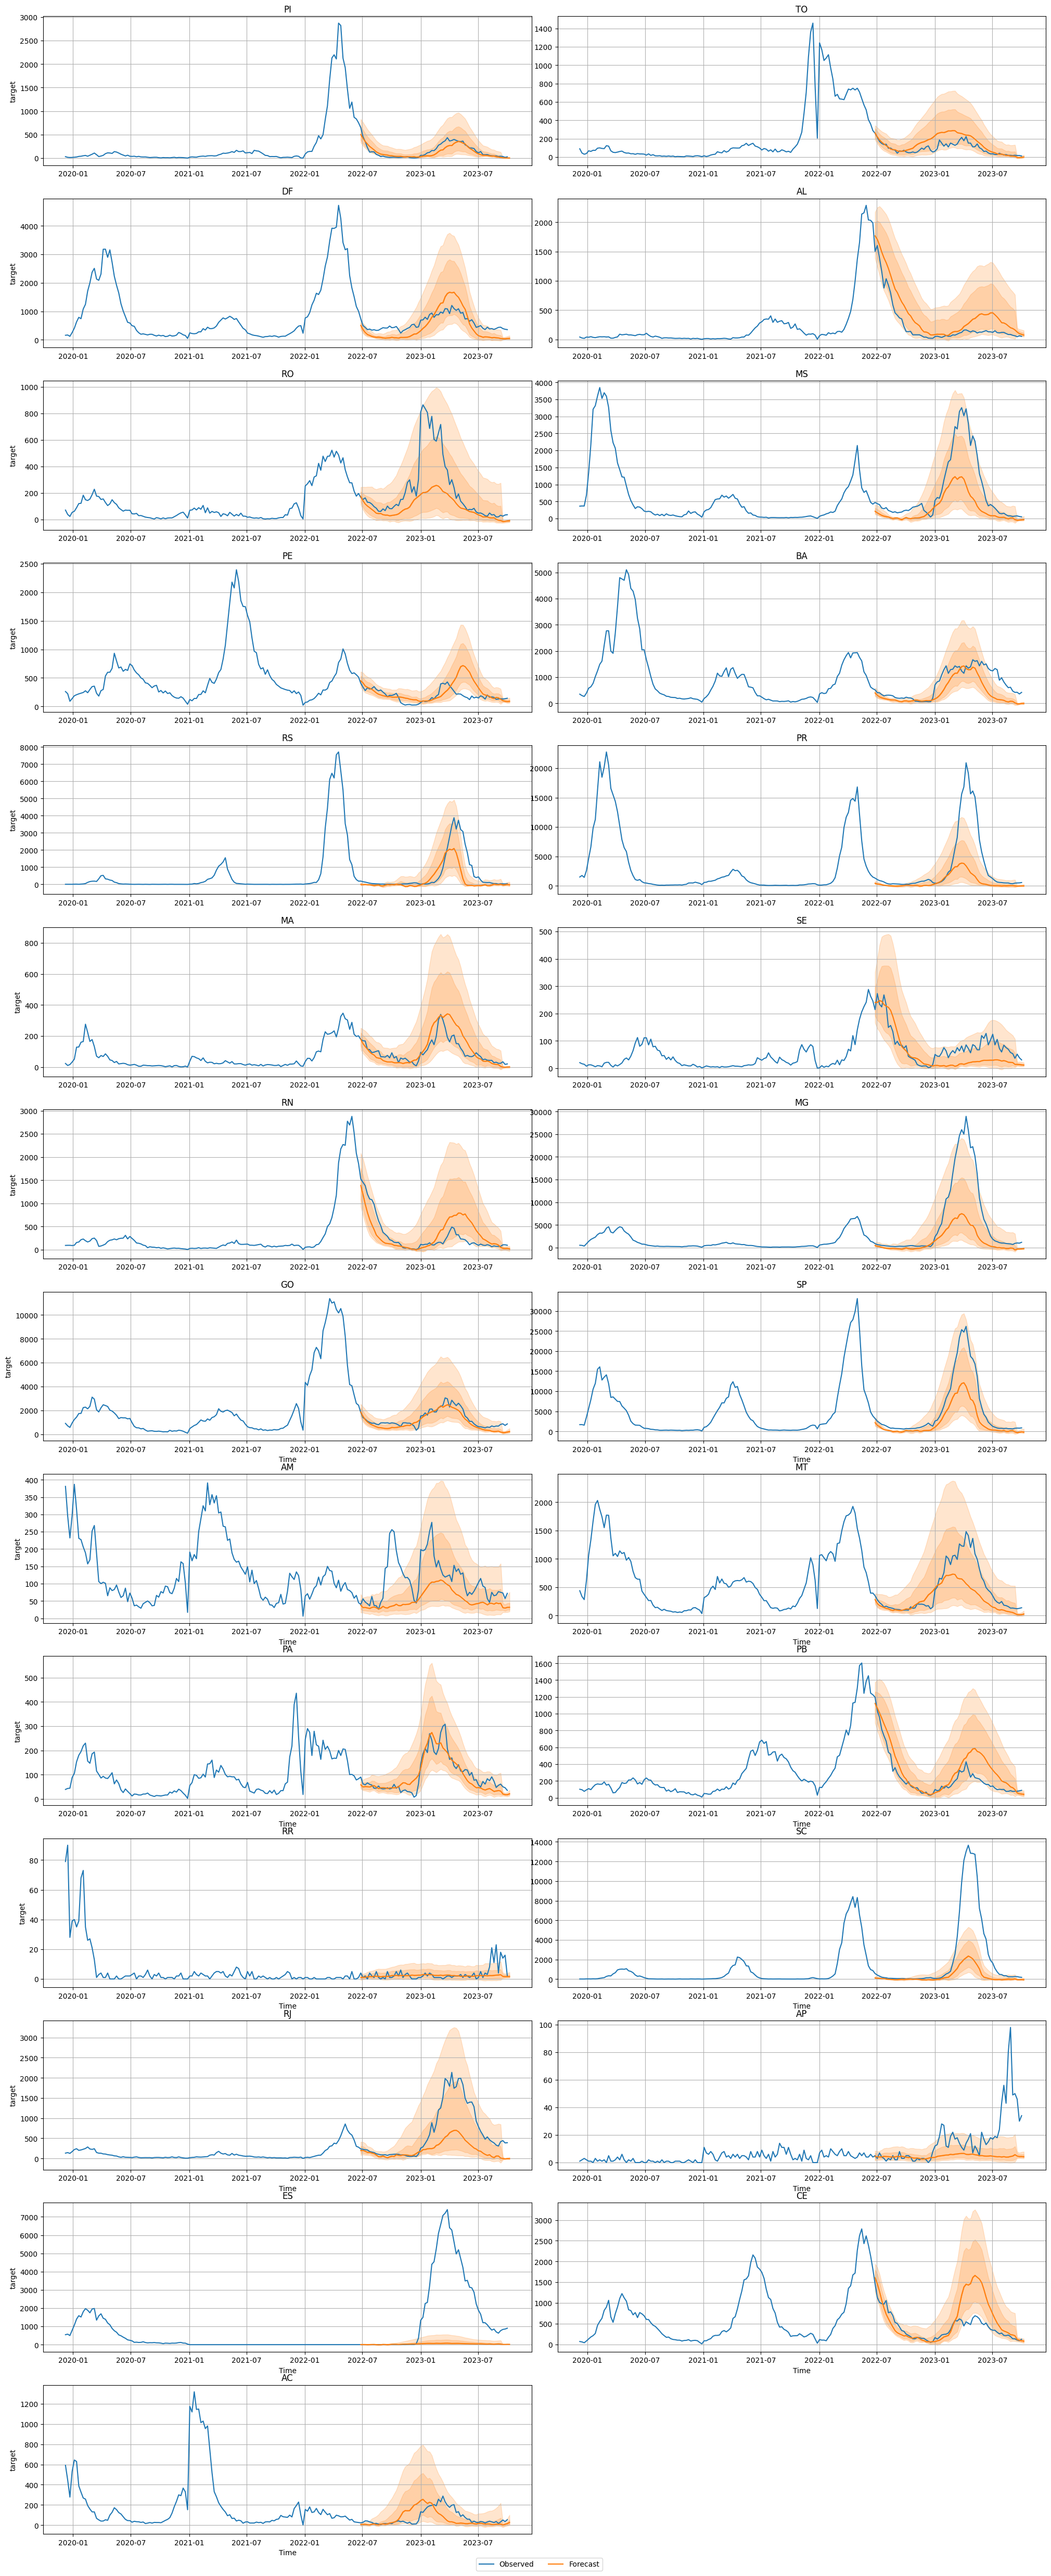

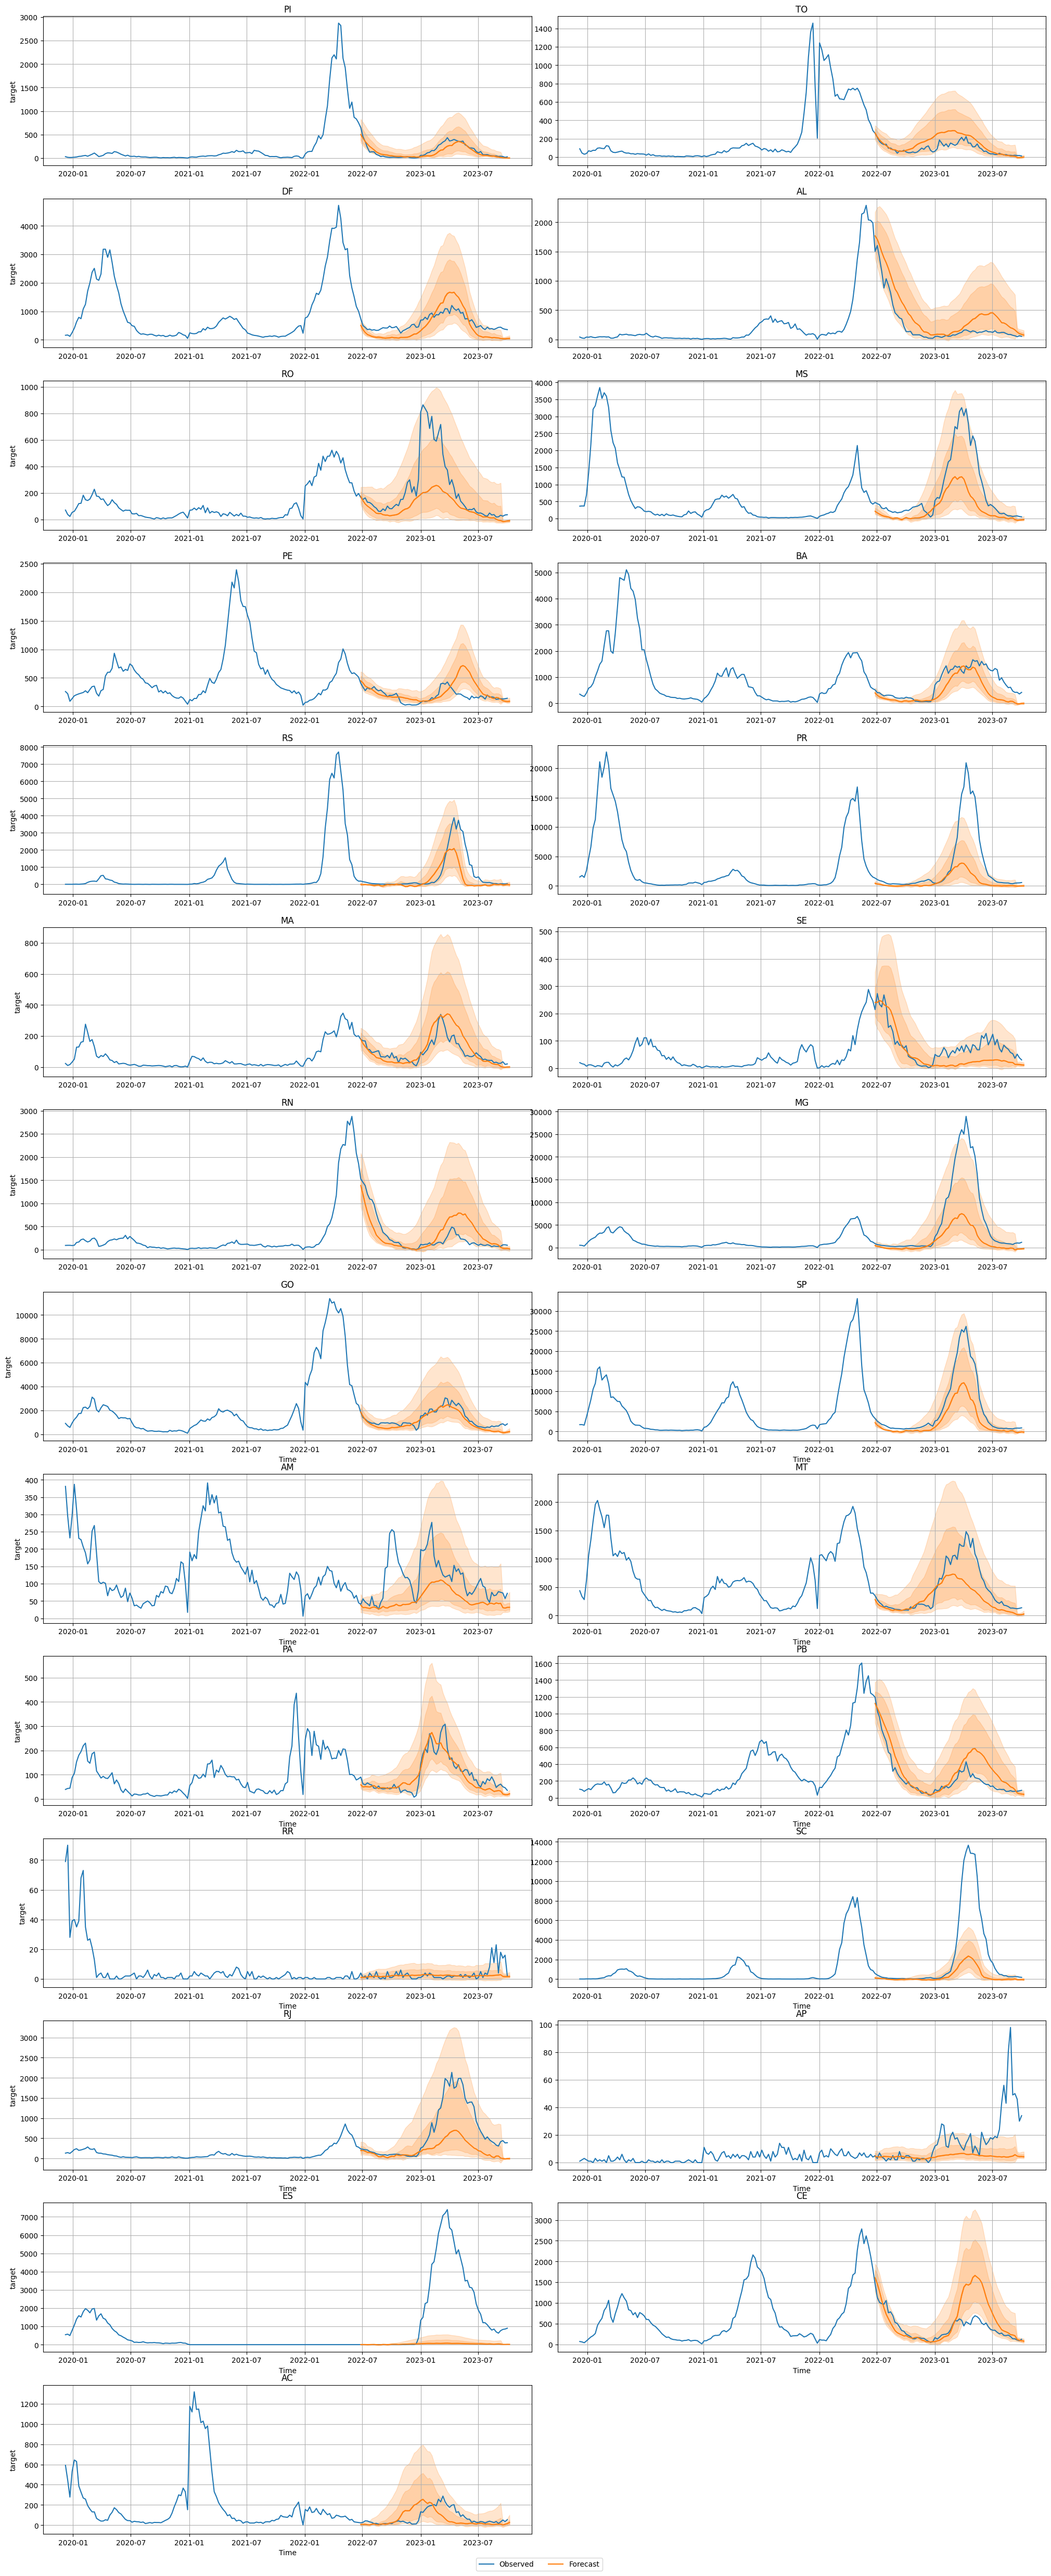

In [15]:
ufs = pd.unique(data['uf'])
predictor.plot(
    data=pd.concat([train_1,test_1]),
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    predictions=predictions,
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=200,
)

In [219]:
intervals = [0.5,0.8,0.9,0.95]

quantiles = [[np.round(0.5 - i/2,decimals=3), np.round(0.5 + i/2,decimals=3)]for i in intervals]
quantiles

[[np.float64(0.25), np.float64(0.75)],
 [np.float64(0.1), np.float64(0.9)],
 [np.float64(0.05), np.float64(0.95)],
 [np.float64(0.025), np.float64(0.975)]]

In [244]:
def estimate_quantile(predictions,target_quantile):
    quantile_values = np.arange(0.1,1.0, 0.1)
    if target_quantile in quantile_values:
        return predictions[str(target_quantile)]
    if target_quantile < 0.1:
        return predictions['0.1'] - (0.1 - target_quantile)*(predictions['0.2'] - predictions['0.1'])/0.1
    if target_quantile > 0.9:
        return predictions['0.9'] + (target_quantile - 0.9)*(predictions['0.9'] - predictions['0.8'])/0.1

    lower_bound = np.round(max(q for q in quantile_values if q < target_quantile),decimals=2)
    upper_bound = np.round(min(q for q in quantile_values if q > target_quantile),decimals=2)
    lower_values = predictions[str(lower_bound)]
    upper_values = predictions[str(upper_bound)]
    slope = (upper_values - lower_values) / (upper_bound - lower_bound)
    return lower_values + slope * (target_quantile - lower_bound)

for q in np.hstack(quantiles):
    predictions[str(q)] = predictions.apply(lambda row: estimate_quantile(row, target_quantile=q), axis=1)

In [245]:
# predictions.iloc[0index_values = predictions.index.tolist()
# column_values = predictions.iloc[:, 0].tolist()
# result = list(zip(index_values, column_values))


# predictions['0.05'] = -(predictions['0.2'] - predictions['0.1']) * 0.5 + predictions['0.1']
# predictions['0.95'] = -(predictions['0.8'] - predictions['0.9']) * 0.5 + predictions['0.9']
i = 2
sample = pl.DataFrame(
    {'q':predictions.iloc[i].index.values[1:].astype(float),
    'y':predictions.iloc[i].values[1:],}
)

(
    ggplot(data=sample)
    + geom_line(aes(x='q', y='y'), color='blue')
    + geom_point(aes(x='q', y='y'), color='blue')
)

In [107]:
# pl.DataFrame(predictions.reset_index()).with_columns(
#     pl.col('0.1')
# )

predictions['0.05'] = (predictions['0.2'] - predictions['0.1'])/0.1* 0.05 - predictions['0.1']

In [72]:
# predictions.iloc[0]
prediction_length

mean         0.1         0.2         0.3  \
item_id timestamp                                                    
PI      2022-06-26  500.846375  331.904968  385.644470  424.650208   
        2022-07-03  421.814545  263.235718  307.957275  345.351746   
        2022-07-10  354.368683  212.181610  251.414185  286.732086   
        2022-07-17  299.772614  167.316010  204.240936  233.675476   
        2022-07-24  249.081207  128.413834  158.303452  186.638962   
...                        ...         ...         ...         ...   
SP      2023-09-10  -86.255859 -625.925781 -382.723145 -190.921387   
        2023-09-17 -270.339844 -542.479492 -410.047363 -333.582520   
        2023-09-24 -161.609375 -314.050781 -259.943848 -193.796875   
        2023-10-01  -61.271484 -367.492188 -216.872559 -122.902344   
        2023-10-08 -136.259277 -459.680664 -277.250977 -179.130859   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
PI      2022-06-26  465.387878  500.846375  541.481873  593.982788   
        2022-07-03  383.562653  421.814545  461.873322  517.966553   
        2022-07-10  319.315857  354.368683  393.526672  442.438416   
        2022-07-17  266.889679  299.772614  335.832367  381.717926   
        2022-07-24  214.594742  249.081207  285.652832  330.989319   
...                        ...         ...         ...         ...   
SP      2023-09-10  -87.312988  -86.255859 -134.175781  -36.981445   
        2023-09-17 -295.016602 -270.339844 -253.695312 -222.838867   
        2023-09-24 -159.967773 -161.609375  -87.332520 -114.747070   
        2023-10-01 -119.753906  -61.271484  -47.246582  -77.795898   
        2023-10-08 -187.824219 -136.259277 -158.131836 -196.688965   

                           0.8          0.9        0.05  
item_id timestamp                                        
PI      2022-06-26  673.262878   827.832275 -305.035217  
        2022-07-03  599.713867   760.430786 -240.874939  
        2022-07-10  524.942383   687.574707 -192.565323  
        2022-07-17  456.232300   611.389404 -148.853546  
        2022-07-24  402.312225   551.593750 -113.469025  
...                        ...          ...         ...  
SP      2023-09-10  454.273193  2381.777832  747.527100  
        2023-09-17 -168.727539   135.711426  608.695557  
        2023-09-24  -75.232422   316.276611  341.104248  
        2023-10-01  -49.764648   536.547363  442.802002  
        2023-10-08 -130.343750   653.496338  550.895508  

[1836 rows x 11 columns]